Principal components analysis (PCA) is a mainstay of population genetics, providing a model-free method for exploring patterns of relatedness within a collection of individuals. PCA was introduced as a tool for genetic genetic analysis by [Patterson, Price & Reich (2006)](http://journals.plos.org/plosgenetics/article?id=10.1371/journal.pgen.0020190). Subsequently [Gil McVean (2009)](http://journals.plos.org/plosgenetics/article?id=10.1371/journal.pgen.1000686) provided an analytical framework for understanding PCA in terms of genetic ancestry. However, although PCA is widely used and the analytical details are worked out, there are a number of practical issues that come up when trying to run PCA on a particular dataset and interpret the results. For example, small changes in how you prepare the input data can make a big difference to the outputs. The [Ag1000G phase 1 data](http://www.malariagen.net/data/ag1000g-phase1-ar3) provide a concrete illustration of some of these issues, so I thought I'd try to bring together some experiences here.

Also, while PCA is fairly quick to run on smaller datasets, it can become slow and memory-intensive with larger data. A few months ago I discovered that [scikit-learn](http://scikit-learn.org/stable/) includes a [randomized SVD](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.RandomizedPCA.html) implementation, which is a potentially faster and more scalable method for approximating the top N components than using a conventional singular value decomposition. To evaluate randomized PCA I implemented some PCA functions in [scikit-allel](http://scikit-allel.readthedocs.org) which provide a convenience layer between underlying SVD implementations in NumPy and scikit-learn and the typical data structures I used to store genotype data. I know others have also started working with randomized PCA for genotype data ([Galinsky et al. 2015](http://biorxiv.org/content/early/2015/04/16/018143)) so I thought it would be interesting to apply both Python SVD implementations to a non-human dataset and report some performance data.

## Setup

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')
sns.set_style('ticks')
import bcolz
import pandas
import allel
import time
time_before = time.time()

I have a copy of the [Ag1000G phase 1 AR3 data release](http://www.malariagen.net/data/ag1000g-phase1-ar3) on a local drive. The SNP genotype data is available in an HDF5 file.

In [2]:
callset_fn = '/data/coluzzi/ag1000g/data/phase1/release/AR3/variation/main/hdf5/ag1000g.phase1.ar3.pass.h5'
callset = h5py.File(callset_fn, mode='r')
callset

<HDF5 file "ag1000g.phase1.ar3.pass.h5" (mode r)>

Let's work with chromosome arm 3L.

In [3]:
chrom = '3L'

Load all the genotype data into memory as a [compressed array](http://bcolz.blosc.org/).

In [4]:
g = allel.GenotypeCArray.from_hdf5(callset[chrom]['calldata']['genotype'], 
                                   cparams=bcolz.cparams(cname='zlib', clevel=1, shuffle=False))
g

,0,1,2,3,4,...,760,761,762,763,764
0,0/0,0/0,0/0,0/0,0/0,...,0/0,0/0,0/0,0/0,0/0
1,0/0,0/0,0/0,0/0,0/0,...,0/0,0/0,0/0,0/0,0/0
2,0/0,0/0,0/0,0/0,0/0,...,0/0,0/0,0/0,0/0,0/0
3,0/0,0/0,0/0,0/0,0/0,...,0/0,0/0,0/0,0/0,0/0
4,0/0,0/0,0/0,0/0,0/0,...,0/0,0/0,0/0,0/0,0/0


Count alleles at each variant.

In [5]:
ac = g.count_alleles()

Before going any further, I'm going to remove singletons and multiallelic SNPs. Singletons are not informative for PCA, and the analysis is simpler if we restrict to biallelic SNPs.

But just for interest, how many multiallelic SNPs are there?

In [6]:
np.count_nonzero(ac.max_allele() > 1)

2193707

How many singletons?

In [7]:
np.count_nonzero((ac.max_allele() == 1) & (ac[:, :2].min(axis=1) <= 1))

2624157

Apply the filtering.

In [8]:
flt = (ac.max_allele() == 1) & (ac[:, :2].min(axis=1) > 1)
gf = g.compress(flt, axis=0)
gf

,0,1,2,3,4,...,760,761,762,763,764
0,0/0,0/0,0/0,0/0,0/0,...,0/0,0/0,0/0,0/0,0/0
1,0/0,0/0,0/0,0/0,0/0,...,0/0,0/0,0/0,0/0,0/0
2,0/0,0/0,0/0,0/0,0/0,...,0/0,0/0,0/0,0/0,0/0
3,0/0,0/0,0/0,0/0,0/0,...,0/0,0/0,0/0,0/0,0/0
4,0/0,0/0,0/0,0/0,0/0,...,0/0,0/0,0/0,0/0,0/0


Finally, transform the genotype data into a 2-dimensional matrix where each cell has the number of non-reference alleles per call. This is what we'll use as the input to PCA.

In [9]:
gn = gf.to_n_alt()
gn

CArrayWrapper((4825329, 765), int8)
  nbytes: 3.44 GB; cbytes: 209.25 MB; ratio: 16.82
  cparams := cparams(clevel=1, shuffle=False, cname='zlib')
[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]

## Removing correlated features (LD pruning)

PCA assumes that the features you provide as input are independent from each other. Here each SNP is a feature, however, because DNA is transmitted from one generation to the next with some recombination between parents, genotypes at nearby SNPs tend to be correlated, with the correlation (linkage disequlibrium) decaying as you increase the separation between SNPs.

We can get a sense of that correlation structure by visualising pairwise linkage disequilibrium in the first 1000 SNPs.

In [10]:
def plot_ld(gn):
    m = allel.stats.rogers_huff_r(gn) ** 2
    allel.plot.pairwise_ld(m)

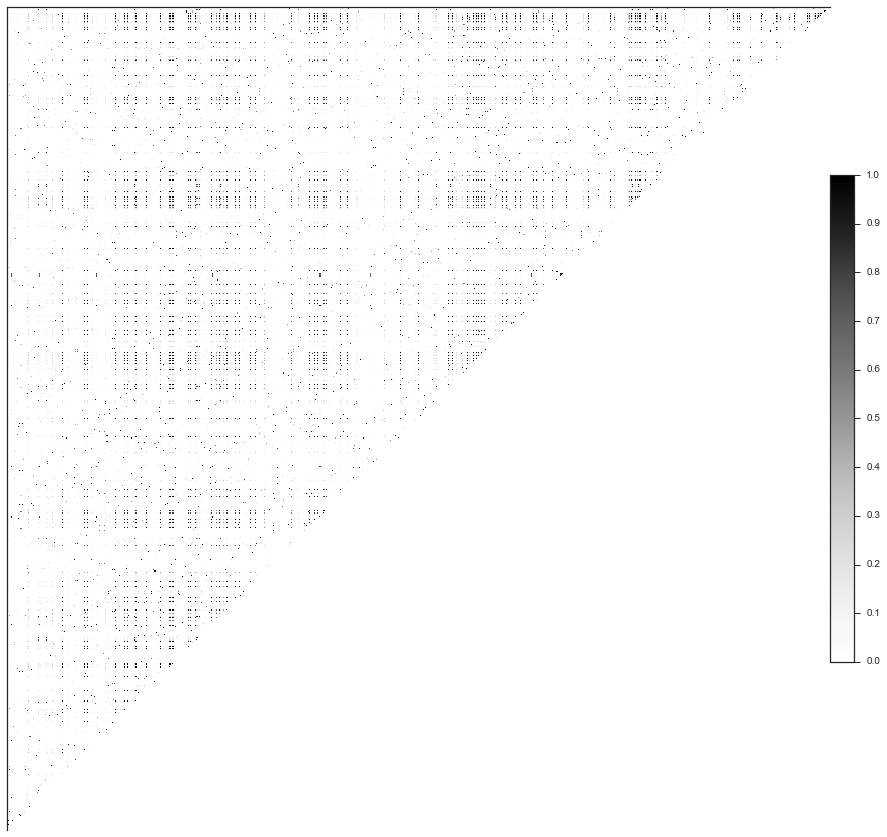

In [11]:
plot_ld(gn[:1000])

The darker regions in the plot above indicate pairs of SNPs where genotypes are highly correlated.

Before I deal with this correlation directly, I'm going to thin down the data a bit. There are 4,825,329 SNPs left after the initial filtering steps above, and analysing this many features is going to be slow. Here we are more concerned with running an exploratory analysis, so I'm going to randomly choose a subset of these SNPs to work with. This should still reveal the main signals in the data, while making runtime faster. 

In [12]:
# number of SNPs to choose randomly
n = 100000
vidx = np.random.choice(gn.shape[0], n, replace=False)
vidx.sort()
gnr = gn.take(vidx, axis=0)
gnr

CArrayWrapper((100000, 765), int8)
  nbytes: 72.96 MB; cbytes: 4.86 MB; ratio: 15.00
  cparams := cparams(clevel=1, shuffle=False, cname='zlib')
[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 2 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]

By randomly downsampling SNPs, this should have dealt with much of the correlation between nearby features. Let's take a look at the first 1000.

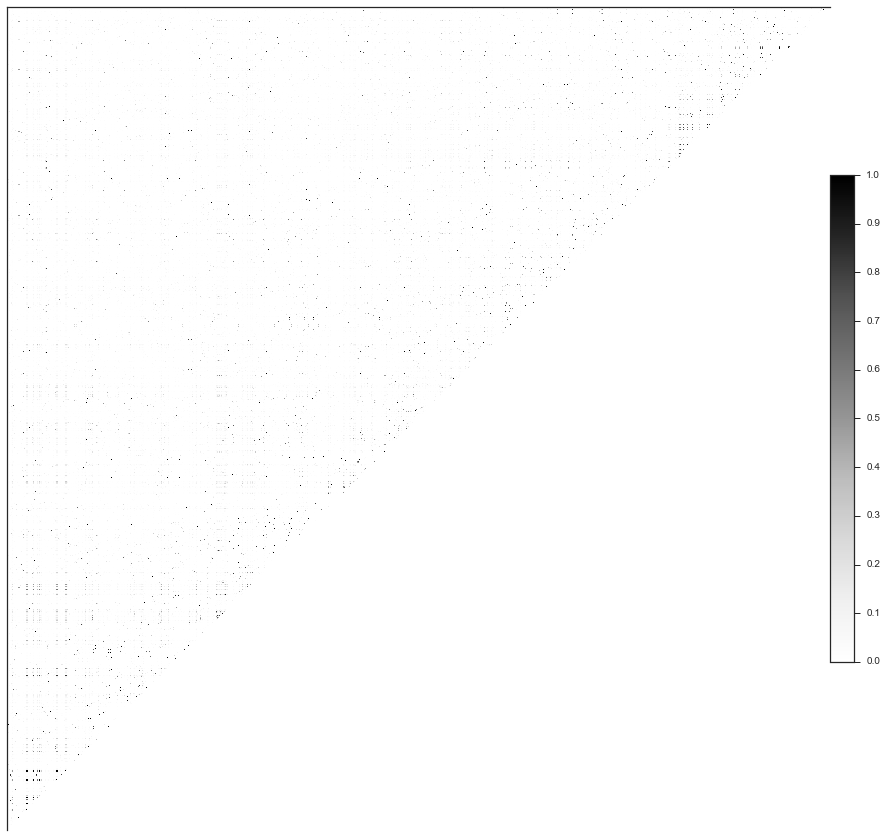

In [13]:
plot_ld(gnr[:1000])

You can see that much of the correlation is gone. However, depending how dusty your screen is, you may be able to see some speckling, indicating that there are still some correlated SNPs in the dataset.

To remove this remaining correlation, I'm going to explicitly locate SNPs that are not correlated with each other, using the `locate_unlinked` function from scikit-allel. This is known as LD pruning, and works by sliding a window along the data, computing pairwise LD between all SNPs within each window.

Conventionally, LD pruning is run just once, however I'm going to be ultra-conservative and run several iterations. In some cases this may make a difference to the results, in others it may not, probably depending on how much long-range LD is present in your samples. Running multiple iterations does slow things down a bit, but it's interesting to demonstrate and see what the effect is.

In [14]:
def ld_prune(gn, size, step, threshold=.1, n_iter=1):
    for i in range(n_iter):
        loc_unlinked = allel.stats.locate_unlinked(gn, size=size, step=step, threshold=threshold)
        n = np.count_nonzero(loc_unlinked)
        n_remove = gn.shape[0] - n
        print('iteration', i+1, 'retaining', n, 'removing', n_remove, 'variants')
        gn = gn.compress(loc_unlinked, axis=0)
    return gn

In [15]:
gnu = ld_prune(gnr, size=500, step=200, threshold=.1, n_iter=10)

iteration 1 retaining 56221 removing 43779 variants
iteration 2 retaining 47019 removing 9202 variants
iteration 3 retaining 44187 removing 2832 variants
iteration 4 retaining 42919 removing 1268 variants
iteration 5 retaining 42200 removing 719 variants
iteration 6 retaining 41766 removing 434 variants
iteration 7 retaining 41470 removing 296 variants
iteration 8 retaining 41299 removing 171 variants
iteration 9 retaining 41114 removing 185 variants
iteration 10 retaining 40992 removing 122 variants


CArrayWrapper((40992, 765), int8)
  nbytes: 29.91 MB; cbytes: 3.17 MB; ratio: 9.44
  cparams := cparams(clevel=1, shuffle=False, cname='zlib')
[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 2 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]

10 iterations is probably way more than what is necessary for this dataset, as you can see few SNPs are removed in the last five iterations.

Let's take a look at how much LD is left.

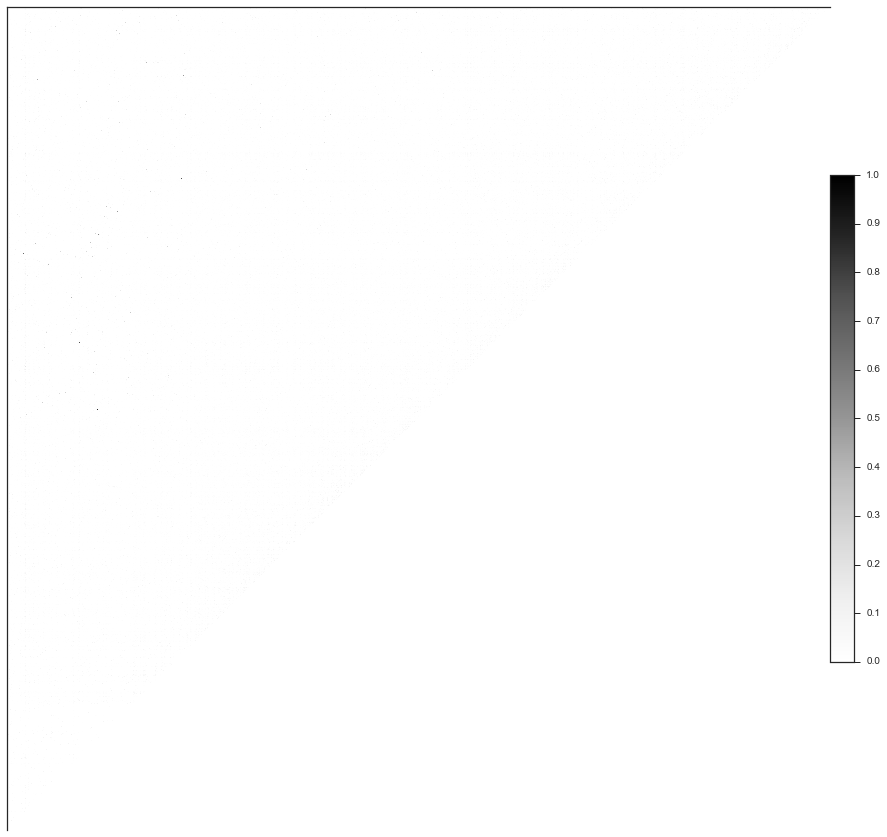

In [16]:
plot_ld(gnu[:1000])

## PCA via conventional SVD

Let's run a conventional PCA analysis of the LD-pruned genotype data.

In [17]:
coords, model = allel.stats.pca(gnu, n_components=10, scaler='patterson')

To help visualise the results, I need to pull in some metadata about which population each individual mosquito belongs to.

In [18]:
df_samples = pandas.read_csv('/data/coluzzi/ag1000g/data/phase1/release/AR3/samples/samples.meta.txt',
                             delimiter='\t', index_col='index')
df_samples.head()

,ox_code,src_code,sra_sample_accession,population,country,region,contributor,contact,year,m_s,sex,n_sequences,mean_coverage,latitude,longitude
index,,,,,,,,,,,,,,,
0,AB0085-C,BF2-4,ERS223996,BFS,Burkina Faso,Pala,Austin Burt,Sam O'Loughlin,2012,S,F,89905852,28.01,11.150,-4.235
1,AB0087-C,BF3-3,ERS224013,BFM,Burkina Faso,Bana,Austin Burt,Sam O'Loughlin,2012,M,F,116706234,36.76,11.233,-4.472
2,AB0088-C,BF3-5,ERS223991,BFM,Burkina Faso,Bana,Austin Burt,Sam O'Loughlin,2012,M,F,112090460,23.30,11.233,-4.472
3,AB0089-C,BF3-8,ERS224031,BFM,Burkina Faso,Bana,Austin Burt,Sam O'Loughlin,2012,M,F,145350454,41.36,11.233,-4.472
4,AB0090-C,BF3-10,ERS223936,BFM,Burkina Faso,Bana,Austin Burt,Sam O'Loughlin,2012,M,F,105012254,34.64,11.233,-4.472


In [19]:
df_samples.groupby('population').population.count()

population
AOM     60
BFM     69
BFS     81
CMS    275
GAS     56
GNS     31
GWA     46
KES     44
UGS    103
Name: population, dtype: int64

In [20]:
populations = df_samples.population.unique()
populations

array(['BFS', 'BFM', 'UGS', 'GWA', 'KES', 'CMS', 'AOM', 'GAS', 'GNS'], dtype=object)

In [21]:
pop_colours = {
    'BFM': '#FF0000',
    'GAS': '#008000',
    'GNS': '#00FFFF',
    'UGS': '#90EE90',
    'GWA': '#FFA500',
    'AOM': '#8B0000',
    'BFS': '#1E90FF',
    'KES': '#808080',
    'CMS': '#0000FF',
}

In [22]:
def plot_pca(coords, model, pc1, pc2):
    fig, ax = plt.subplots(figsize=(6, 6))
    sns.despine(ax=ax, offset=5)
    x = coords[:, pc1-1]
    y = coords[:, pc2-1]
    for pop in populations:
        flt = (df_samples.population == pop).values
        ax.plot(x[flt], y[flt], marker='o', linestyle=' ', color=pop_colours[pop], label=pop, markersize=6, mec='k', mew=.5)
    ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
    ax.set_xlabel('PC%s (%.1f%%)' % (pc1, model.explained_variance_ratio_[pc1-1]*100))
    ax.set_ylabel('PC%s (%.1f%%)' % (pc2, model.explained_variance_ratio_[pc2-1]*100))
    

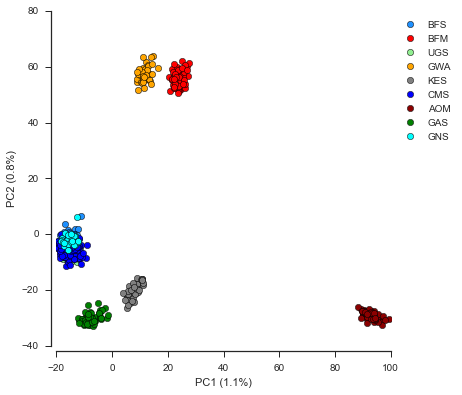

In [23]:
plot_pca(coords, model, 1, 2)

I've only shown the first two components above, but there is a clear separation of individuals into a number of different clusters. This gives us a strong indication that there are a number of genetically distinct populations represented by the mosquitoes we've sequenced.

## Effect of LD pruning

What would happen if we ran the PCA on the data prior to removing correlated SNPs?

In [ ]:
coords, model = allel.stats.pca(gnu, n_components=10, scaler='patterson')
plot_pca(coords, model, 1, 2)

@@COMMENT

## Effect of scaling

TODO

## Effect of unequal sample sizes

TODO

## Randomized PCA

TODO

## Conclusions

TODO

## Further reading

TODO